In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchmetrics
from tqdm import tqdm
from torchtext.vocab import GloVe, vocab
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt

/home/sushovan/.local/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
train_path = 'Train.xlsx'

In [3]:
df_train = pd.read_excel(train_path,engine='openpyxl')

In [4]:
import re
def clean(text):
    text = re.sub(r"http\S+", " ", text) # remove urls
    text = re.sub(r"RT ", " ", text) # remove rt
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text) # remove special character except # @ . ,
    text = re.sub(r'\t', ' ', text) # remove tabs
    text = re.sub(r'\n', ' ', text) # remove line jump
    text = re.sub(r"\s+", " ", text) # remove extra white space
    text = text.strip()
    return text

In [5]:
df_train['content_original'] = df_train['content_original'].str.split(' \n\n---\n\n').str[0]
df_train['content_original'] = df_train['content_original'].str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()

df_train['title'] = df_train['title'].str.split(' \n\n---\n\n').str[0]
df_train['title'] = df_train['title'].str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()


df_train.content_original = df_train.content_original.apply(clean)
df_train.title = df_train.title.apply(clean)

In [6]:
unk_token = "<unk>"
unk_index = 0
glove_vectors = GloVe(name='6B', dim=100)
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<unk>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

In [7]:
pretrained_embeddings[glove_vocab['hello']]

tensor([ 2.0972e-01, -9.7601e-01, -3.4845e-02, -4.4451e-01,  5.7553e-01,
        -5.5722e-01, -4.8259e-02,  8.8938e-01, -3.8567e-01, -6.0122e-01,
         1.4689e-01,  2.3241e-01, -2.0206e-01, -1.2475e-01,  2.2172e-01,
        -7.9488e-01,  1.8551e-04, -4.6308e-01, -7.6648e-02,  1.8384e-01,
         9.2898e-02,  1.6110e-01,  3.7590e-01, -9.7123e-01,  1.1706e+00,
        -2.3141e-01, -6.8350e-01, -1.3191e-01, -4.8528e-01,  4.8536e-01,
         8.7823e-02,  2.4492e-01, -2.8698e-01, -3.9631e-02,  4.8862e-02,
        -3.0619e-01, -6.2387e-01,  1.9994e-01,  6.4592e-02, -1.0950e-01,
        -2.6365e-01,  1.3784e-02, -1.1060e+00,  3.0101e-01,  6.1965e-01,
         1.4128e+00,  5.8870e-01, -2.1358e-01,  5.2177e-01,  7.6162e-01,
        -2.9929e-01,  4.3983e-01,  1.2749e+00,  7.3642e-01, -9.9978e-01,
        -1.1642e+00, -2.6165e-01, -5.3110e-01,  3.3104e-03, -4.6568e-01,
        -3.6465e-01,  4.4717e-02,  7.8665e-03,  6.6572e-01,  2.8863e-01,
         3.7517e-01, -4.0419e-01, -2.0311e-01,  7.3

In [8]:
pretrained_embeddings.shape

torch.Size([400001, 100])

In [9]:
tokenizer = get_tokenizer("basic_english")
example_text = "hello how are you ?"
tokens = tokenizer(example_text)
indices = glove_vocab(tokens)
max_len = 120
padded_indices = indices[:max_len] + [0] * max(0, max_len - len(indices))
text_input = torch.tensor(padded_indices)

In [10]:
text_input.shape

torch.Size([120])

In [11]:
df_train.head(2)

,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,immigration,National Review,2,https://www.nationalreview.com/2018/12/governm...,"shutdown theater, again",2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,president trump and senate minority leader chu...,www.nationalreview.com,right,zl7kc7EmAyIdUMIo
1,1,culture,Yahoo! The 360,1,https://news.yahoo.com/can-the-developing-worl...,can the developing world endure the coronavirus,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,the 360 shows you diverse perspectives on the ...,www.news.yahoo.com,center,xpbjYTJYPdlw6HmJ


In [12]:
from collections import Counter

In [13]:
df_train.bias.value_counts()

bias
2    10241
0     8861
1     7488
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)

(21272, 13)
(5318, 13)


In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
class NQADataset(Dataset):
  def __init__(self,data,max_sentence_length):

    self.data = data
    self.max_sentence_length=max_sentence_length
    self.tokenizer = get_tokenizer("basic_english")
    self.vocab = glove_vocab
   

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]
    
    tokens = self.tokenizer(data_row['content_original'])
    indices = self.vocab(tokens)
    padded_indices = indices[:self.max_sentence_length] + [0] * max(0, self.max_sentence_length - len(indices))
    body = torch.tensor(padded_indices)
    
    
    labels = torch.tensor(data_row['bias'],dtype=torch.long)

    return dict(body = body, 
                labels = labels)

In [19]:
import pytorch_lightning as pl

In [20]:
class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df,test_df,max_sentence_length,batch_size):
    super().__init__()
    
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.batch_size = batch_size
    self.max_sentence_length=max_sentence_length

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.max_sentence_length)
    self.test_dataset = NQADataset(self.test_df,self.max_sentence_length)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,drop_last=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,drop_last=True,num_workers=4)


In [21]:
BS = 48

In [22]:
data_module = NQADataModule(X_train,X_test,max_sentence_length=120,batch_size=BS)
data_module.setup()

In [23]:
# Iterate through the first batch to see a sample
for idx,data in enumerate(data_module.val_dataloader()):
    print(data['body'].shape)
    print(data['labels'].shape)
    break

torch.Size([48, 120])
torch.Size([48])


In [24]:
data_module.test_dataset[0]

{'body': tensor([   118,      0,   1004,      5,      0,   1326,      3,   5350,      1,
             38,     14,     52,      7,   2593,      1,     39,    588,     88,
            424,    401,     46,     36,      0,    742,   1980,     43,   1927,
              1,     16,    684,  34850,      1,    369,      3,      0,  16375,
           1887,      1,      7,   8350,    198,   2166,   1887,      3,    193,
           1822,   1193,      2,     19,     48,      3,      7,   4883,      3,
            590,   5464,      6,      7,  10468,   2567,     92,      1,   5741,
           1534,   3723,      3,      0,  60424,     14,      7,    728,      3,
             26,   1356,      5,    209,  12341,      2,    100,    372,      1,
             26,   2472,      5,    253,   1587,      4,  13587,    193,   1822,
             31, 111356,    143,     10,    103,      7,    288,    396,  16375,
           1887,    896,     55,   4834,      3,    193,  64888,    144,      7,
          28126,    

In [25]:
pl.seed_everything(42)

Global seed set to 123


123

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
class LitLSTM(pl.LightningModule):
    def __init__(self,num_classes,num_heads,embed_dim,hidd_dim,batch_size):
        super(LitLSTM, self).__init__()
        
        self.hidd_dim = hidd_dim
        self.num_layer = 3
        self.embed_dim = embed_dim
        self.batch_size = batch_size
        
        self.Embed = nn.Embedding.from_pretrained(pretrained_embeddings, 
                                                  freeze = True)

        
        self.LSTM = nn.LSTM(input_size=self.embed_dim,
                               hidden_size=self.hidd_dim, 
                               num_layers=self.num_layer, 
                               batch_first=True,
                               dropout=0.4,
                               bias = True,
                               bidirectional=False)

        
        self.model = nn.Sequential( nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(self.hidd_dim, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(64, 32),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(32, num_classes))
        
        self.acc = torchmetrics.classification.Accuracy(num_classes=num_classes,task='multiclass')
        self.trainacc = torchmetrics.classification.Accuracy(num_classes=num_classes,task='multiclass')

        self.lossfn = nn.CrossEntropyLoss(reduction='mean')
        
        self.TLOSS = []
        self.TACC = []
        self.VLOSS = []
        self.VACC = []
        
        self.validation_step_outputs = []
        self.train_step_outputs = []

    def forward(self, body):
        
        body = self.Embed(body)
        
        body, (final_hidden_state_body, final_cell_state_body) = self.LSTM(body) 
        
        # final_hidden_state_head -> (bidrectional*num_layers,bs,hidden_dim)
        # after permute -> (bs,bidrectional*num_layers,hidden_dim)
        # after taking mean() in second axis -> (bs,hidden_dim)
        
        b = final_hidden_state_body.permute(1,0,2).mean(dim=1)
        
        x = self.model(b)
        return x

    def training_step(self, batch, batch_idx):
        labels = batch['labels']
        outputs = self.forward(batch['body'])
        loss = self.lossfn(outputs, labels)
        self.train_step_outputs.append(loss)
        self.trainacc.update(outputs, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        labels = batch['labels']
        outputs = self.forward(batch['body'])
        loss = self.lossfn(outputs, labels)
        self.validation_step_outputs.append(loss)
        self.acc.update(outputs, labels)
        self.log("val_loss", loss)
        
    def on_train_epoch_end(self):
        mean_val = torch.mean(torch.tensor(self.train_step_outputs))
        self.train_step_outputs.clear()
        train_accuracy = self.trainacc.compute()
        self.TACC.append(train_accuracy)
        self.TLOSS.append(mean_val)
        self.trainacc.reset()
        self.log_dict({"ETrain_loss" : mean_val,"ETrain_Acc" : train_accuracy},prog_bar=True, on_epoch=True)
        print(f"\n||----------Train Accuracy : {train_accuracy:.4} || Train Loss : {mean_val:.4}-----------||")
        print(f"\n||--------------------------------------------------------------------------||")

      
    def on_validation_epoch_end(self):
        mean_val = torch.mean(torch.tensor(self.validation_step_outputs))
        self.validation_step_outputs.clear()
        val_accuracy = self.acc.compute()
        self.VACC.append(val_accuracy)
        self.VLOSS.append(mean_val)
        self.acc.reset()
        self.log_dict({"EVal_loss" : mean_val,"EVal_Acc" : val_accuracy},prog_bar=True,on_epoch=True)
        print(f"\n||----------Val Accuracy : {val_accuracy:.4} || Val Loss : {mean_val:.4}-----------||")
    
           
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),lr=0.001)

In [40]:
model = LitLSTM(num_heads=8,embed_dim=100,hidd_dim=200,num_classes=3,batch_size=BS)

In [41]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")


In [42]:
trainer = pl.Trainer(devices=-1, 
                     accelerator="gpu",
                     logger = logger,
                     max_epochs = 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model,data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | Embed    | Embedding          | 40.0 M
1 | LSTM     | LSTM               | 884 K 
2 | model    | Sequential         | 15.2 K
3 | acc      | MulticlassAccuracy | 0     
4 | trainacc | MulticlassAccuracy | 0     
5 | lossfn   | CrossEntropyLoss   | 0     
------------------------------------------------
900 K     Trainable params
40.0 M    Non-trainable params
40.9 M    Total params
163.601   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3542 || Val Loss : 1.098-----------||


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.093-----------||

||----------Train Accuracy : 0.3648 || Train Loss : 1.113-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3736 || Train Loss : 1.094-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.38 || Train Loss : 1.092-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3851 || Train Loss : 1.092-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3844 || Train Loss : 1.092-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3852 || Train Loss : 1.092-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3852 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3844 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3832 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3848 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3865 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3865 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3861 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3857 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||

||----------Train Accuracy : 0.3848 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3847 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3855 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.385 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.091-----------||

||----------Train Accuracy : 0.3865 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


Validation: 0it [00:00, ?it/s]


||----------Val Accuracy : 0.3801 || Val Loss : 1.092-----------||


`Trainer.fit` stopped: `max_epochs=20` reached.



||----------Train Accuracy : 0.3867 || Train Loss : 1.091-----------||

||--------------------------------------------------------------------------||


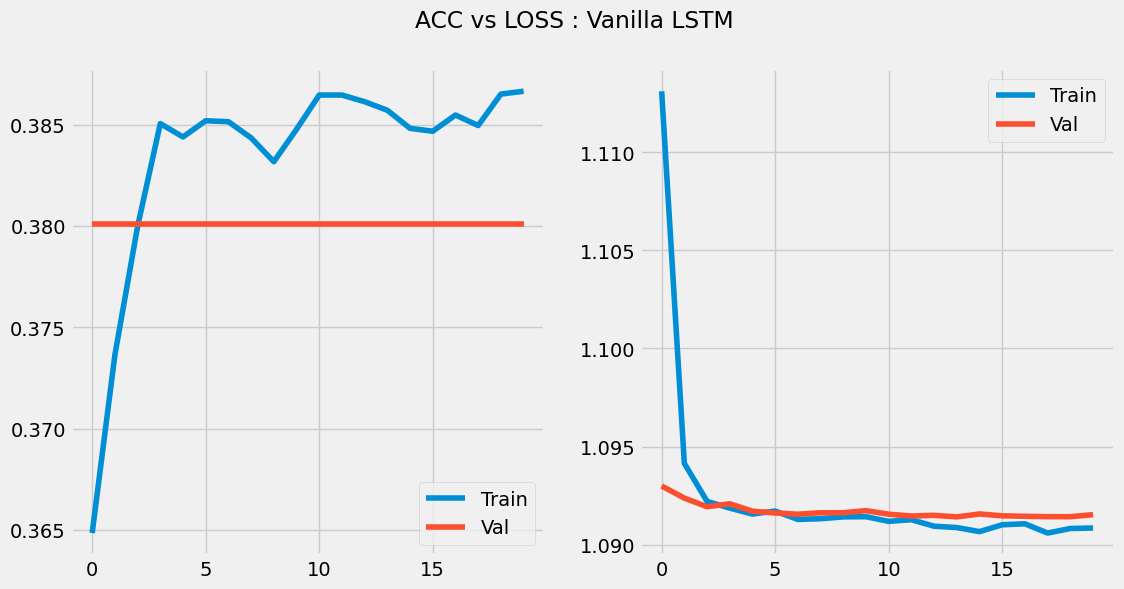

In [45]:
xx = np.arange(20)
plt.style.use("fivethirtyeight")

acctr = torch.Tensor(model.TACC).detach().cpu().numpy()
lsstr = torch.Tensor(model.TLOSS).detach().cpu().numpy()
accte = torch.Tensor(model.VACC).detach().cpu().numpy()
lsste = torch.Tensor(model.VLOSS).detach().cpu().numpy()

accte = accte[1:]
lsste = lsste[1:]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
fig.suptitle('ACC vs LOSS : Vanilla LSTM')
ax1.plot(xx, acctr,label='Train')
ax1.plot(xx,accte,label='Val')
ax1.legend(loc="best")
ax2.plot(xx, lsstr,label='Train')
ax2.plot(xx, lsste,label='Val')
ax2.legend(loc="best")
plt.show()